In [1]:
setwd("/public/workspace202011/mirnome/mirnome_data/")

In [2]:
library(FactoMineR)
library(ggplot2)
library(ggrepel)
library(ggpubr)
library(paletteer)
library(dplyr)
library(gridExtra)
library(tidyverse)
library(pheatmap)
library(reshape2)
library(ggsignif)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.2.1     ✔ purrr   1.0.2
✔ tidyr   1.3.0     ✔ stringr 1.5.1
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ gridExtra::combine() masks dplyr::combine()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::lag()         masks stats::lag()


Attaching package: ‘resh

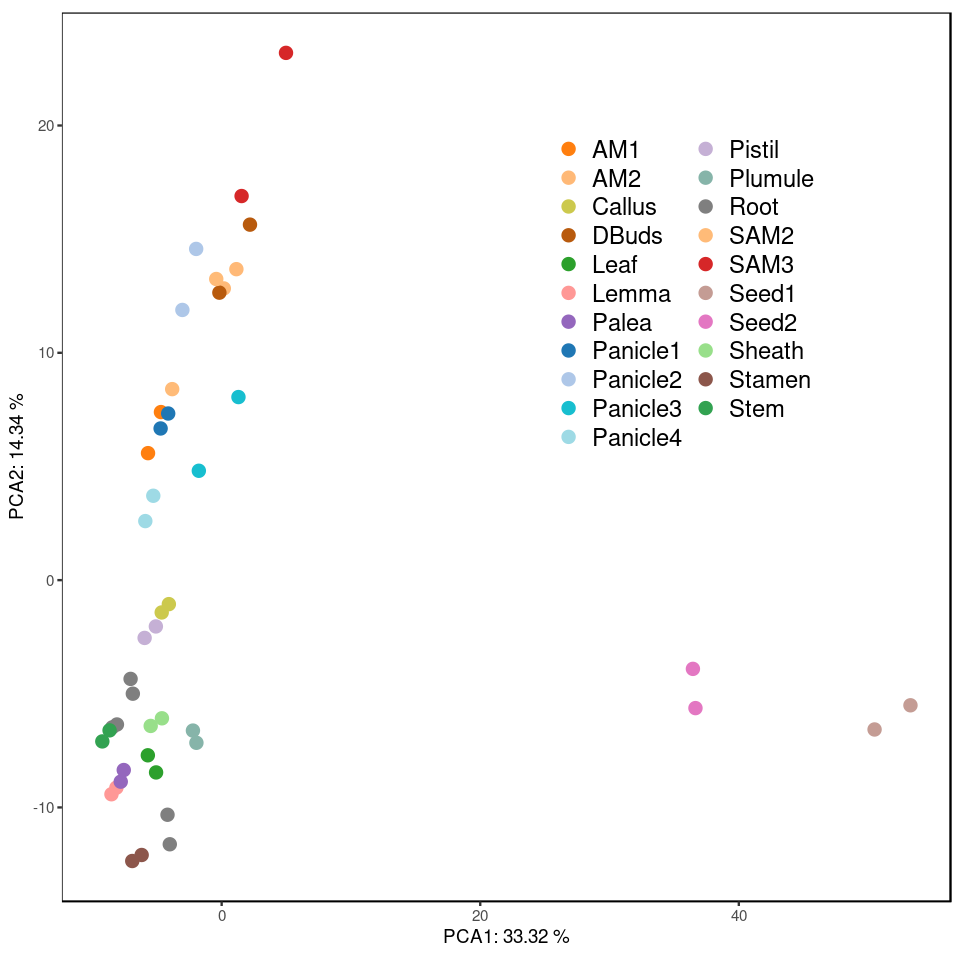

In [3]:
options(repr.plot.height=8,repr.plot.width=8)
expression_matrix <- read.csv('./2_quant/matrix/scale_tpm/microRNA_tpm_rep.csv',sep='\t')
expression_matrix<-t(expression_matrix)
miRNA.pca <- PCA(expression_matrix, ncp = 2, scale.unit = TRUE, graph = FALSE)
pca_sample <- data.frame(miRNA.pca$ind$coord[ ,1:2])
pca_sample$Sample=row.names(pca_sample)
pca_sample$group <- gsub('_rep[12]', '', pca_sample$Sample)
pca_eig1 <- round(miRNA.pca$eig[1,2],2)
pca_eig2 <- round(miRNA.pca$eig[2,2],2)
color <- read.table('./Plot/color_microRNA.txt',comment.char = "@")
mycolor <- setNames(color$V2,color$V1)
library(ggplot2)
p <- ggplot(data = pca_sample, aes(x = Dim.1, y = Dim.2)) +
  geom_point(aes(color = group), size = 3) +  #根据样本坐标绘制二维散点图
  theme(panel.grid = element_blank(), panel.background = element_rect(color = 'black', fill = 'transparent'), 
        legend.key = element_rect(fill = 'transparent')) +  #去除背景和网格线
  labs(x =  paste('PCA1:', pca_eig1, '%'), y = paste('PCA2:', pca_eig2, '%'), color = '',)+scale_color_manual(values = mycolor)+ 
  theme(legend.position = c(0.7, 0.7),legend.text = element_text(size = 14))+ coord_fixed(ratio = (max(pca_sample$Dim.1)-min(pca_sample$Dim.1))/(max(pca_sample$Dim.2)-min(pca_sample$Dim.2)))
p

Warning message:
“Use of `data$percent` is discouraged.
ℹ Use `percent` instead.”
Warning message:
“Use of `data$percent` is discouraged.
ℹ Use `percent` instead.”
Warning message:
“Use of `data$percent` is discouraged.
ℹ Use `percent` instead.”
Warning message:
“Use of `data$percent` is discouraged.
ℹ Use `percent` instead.”


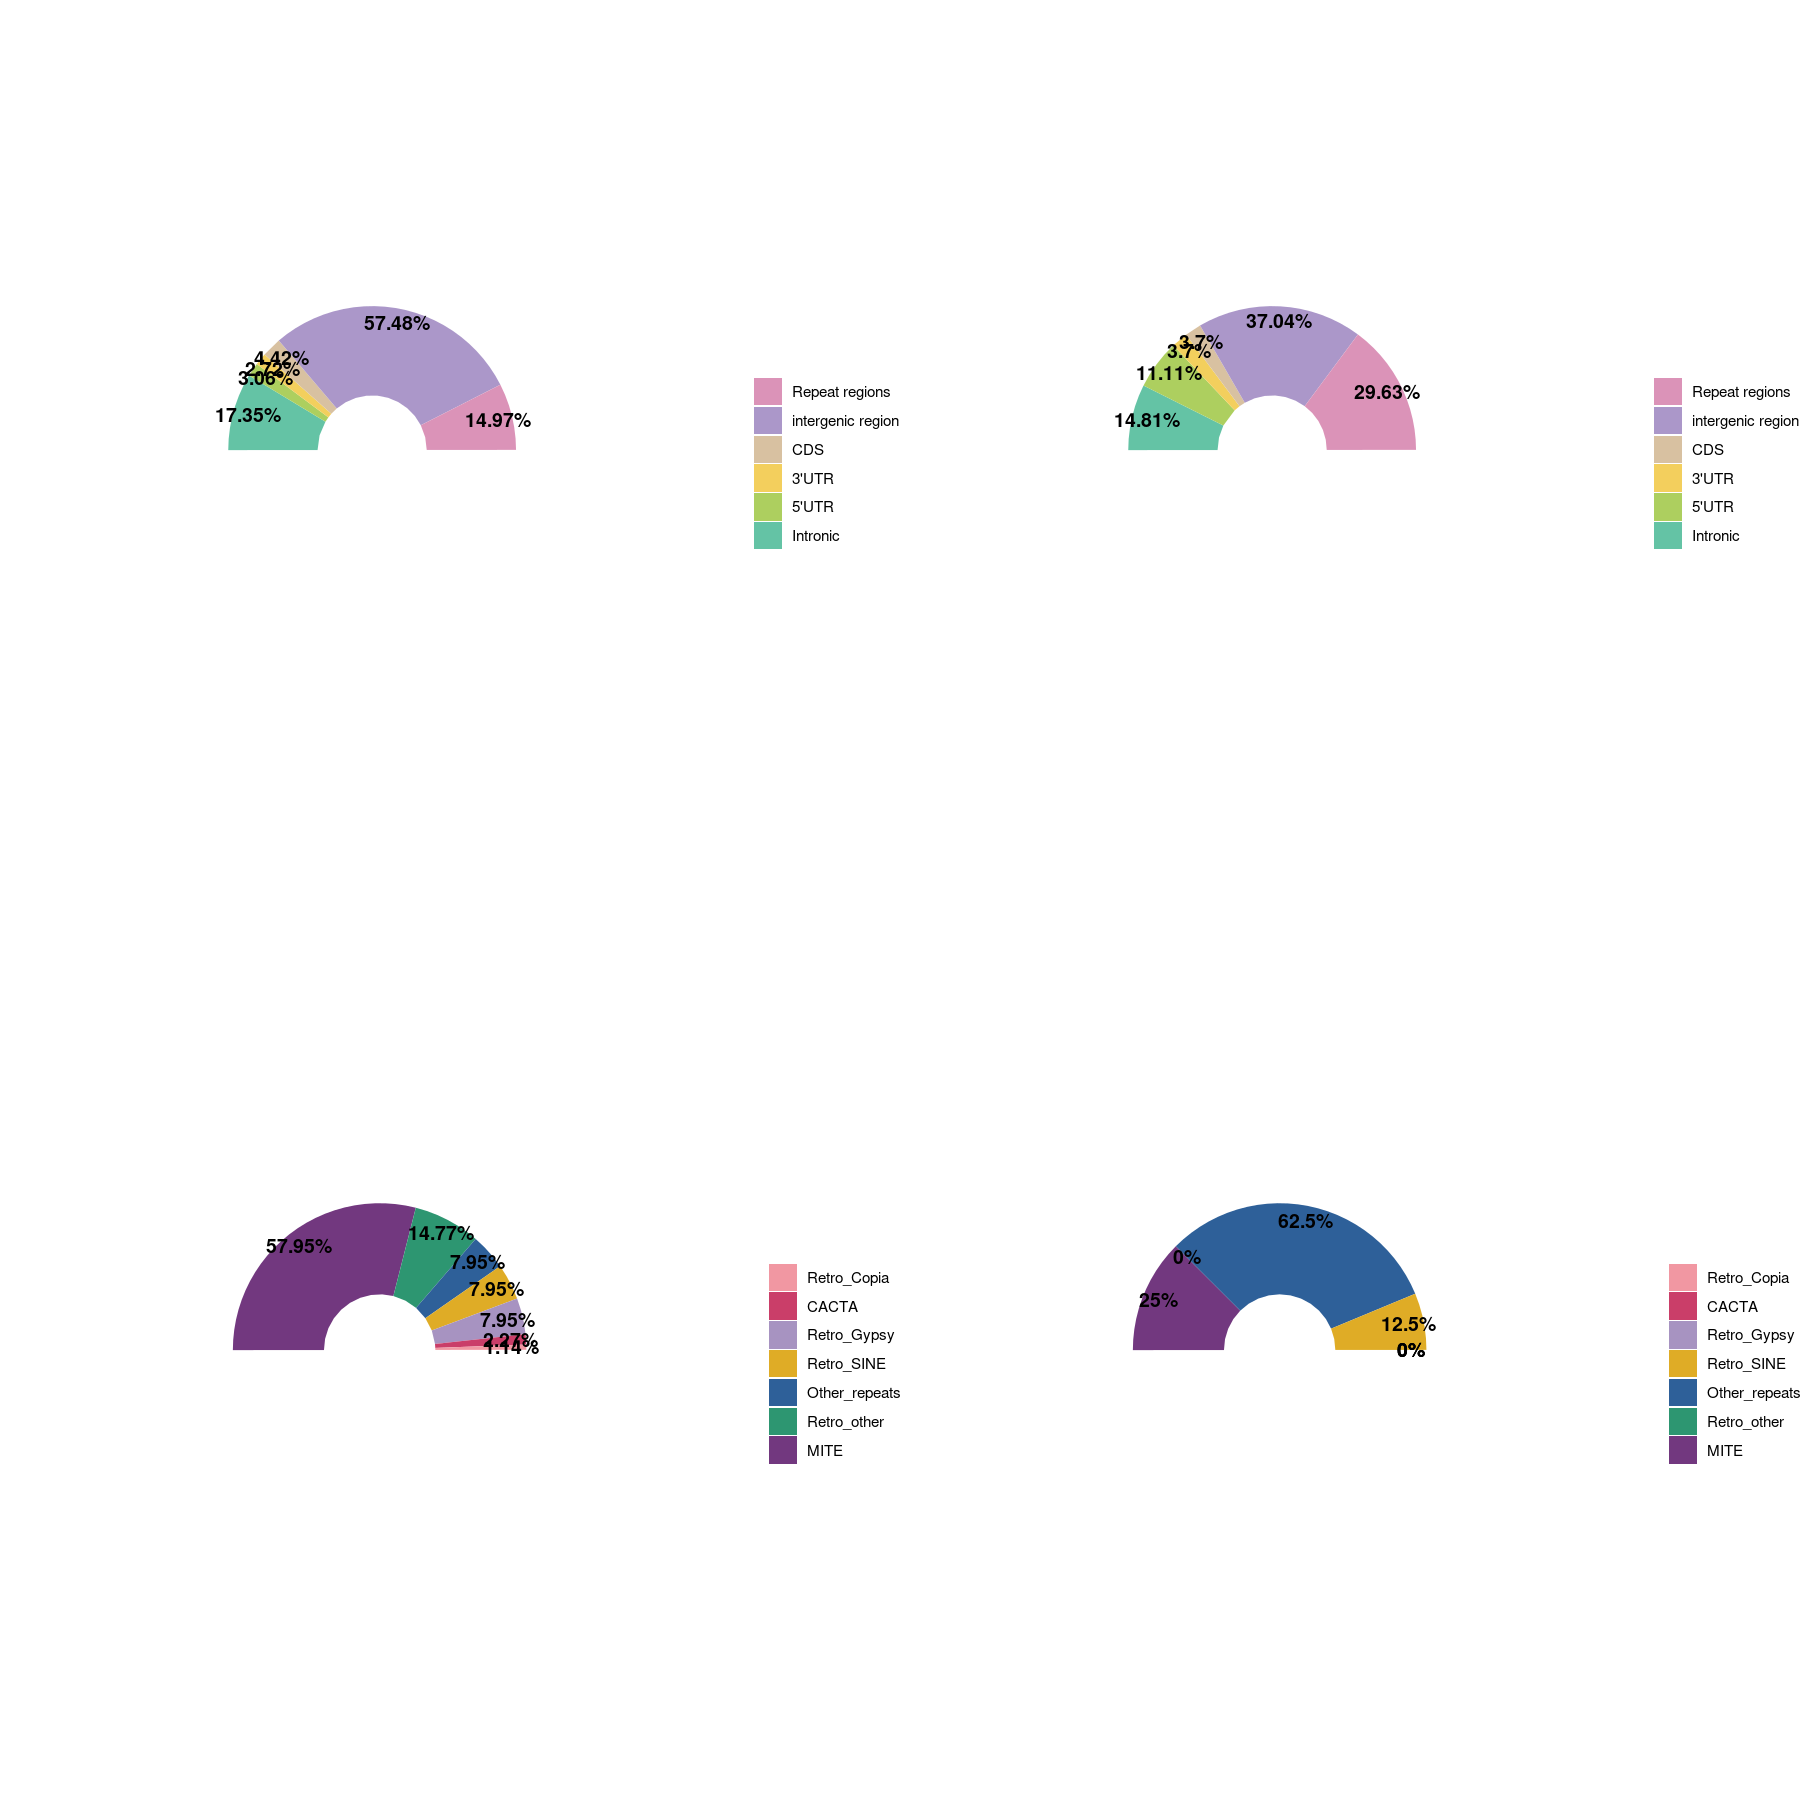

In [4]:
# Function to calculate percent and labels
options(repr.plot.height=15,repr.plot.width=15)
calculate_percent_and_labels <- function(data) {
  data['percent'] <- round(data['val'] / colSums(data['val']) * 100, 2)
  data['lab'] <- cumsum(data$percent) - data$percent / 2
  data['lab2'] <- c(data$percent[1] / 2, cumsum(data$lab[-1] + data$percent[-1] / 2))
  return(data)
}

# Function to create polar plot
create_polar_plot <- function(data, colors) {
  plot <- ggplot() +
    geom_bar(data = data, aes(x = 1, y = percent, fill = item), stat = "identity", position = "stack") +
    geom_text(data = data, aes(x = 1.3, y = lab, label = paste0(round(data$percent,2), '%')), fontface = rep('bold', nrow(data)), size = 4) +
    scale_x_continuous(limits = c(0, 3), expand = c(0, 0)) +
    scale_y_continuous(limits = c(-100, 100)) +
    scale_fill_manual(values = colors) +
    coord_polar(theta = "y", start = 1.57) +
    theme_void() +
    theme(legend.position = "right") +
    guides(fill = guide_legend(title = ""))
  
  return(plot)
}

# Reading data
miRBase_repeats <- read.csv('./Plot/miRBase_repeat_region_category.csv', sep = ',', col.names = c('item', 'val'))
miRBase_unclass <- read.csv('./Plot/miRBase_genomic_location.csv', sep = ',', col.names = c('item', 'val'))
predicted_repeats <- read.csv('./Plot/novel_repeat_category.csv', sep = ',', col.names = c('item', 'val'))
predicted_unclass <- read.csv('./Plot/novel_genomic_location.csv', sep = ',', col.names = c('item', 'val'))

# Calculate percent and labels for each dataset
miRBase_repeats <- calculate_percent_and_labels(miRBase_repeats)
miRBase_unclass <- calculate_percent_and_labels(miRBase_unclass)
predicted_repeats <- calculate_percent_and_labels(predicted_repeats)
predicted_unclass <- calculate_percent_and_labels(predicted_unclass)

miRBase_repeats$item <- factor(miRBase_repeats$item,levels = rev(c("MITE","Retro_other","Other_repeats","Retro_SINE","Retro_Gypsy","CACTA","Retro_Copia")),ordered = TRUE)
miRBase_unclass$item <- factor(miRBase_unclass$item,levels = rev(c("Intronic","5'UTR","3'UTR","CDS","intergenic region","Repeat regions")),ordered = TRUE)
predicted_repeats$item <- factor(predicted_repeats$item,levels = rev(c("MITE","Retro_other","Other_repeats","Retro_SINE","Retro_Gypsy","CACTA","Retro_Copia")),ordered = TRUE)
predicted_unclass$item <- factor(predicted_unclass$item,levels = rev(c("Intronic","5'UTR","3'UTR","CDS","intergenic region","Repeat regions")),ordered = TRUE)

# Define color schemes
col7 <- rev(c("#72387F", "#2D9671", "#2E6099", "#DFAC26", "#A793C1", "#CA3E69", '#F197A2'))
col6 <- rev(c("#64C3A5", "#ADCF5F", "#F3CF5D", "#D8C1A1", "#AB97C9", "#DB93B8"))

# Create polar plots
p1 <- create_polar_plot(miRBase_unclass, col6)
p2 <- create_polar_plot(predicted_unclass, col6)
p3 <- create_polar_plot(miRBase_repeats, col7)
p4 <- create_polar_plot(predicted_repeats, col7)
gridExtra::grid.arrange(p1, p2, p3, p4, nrow = 2)

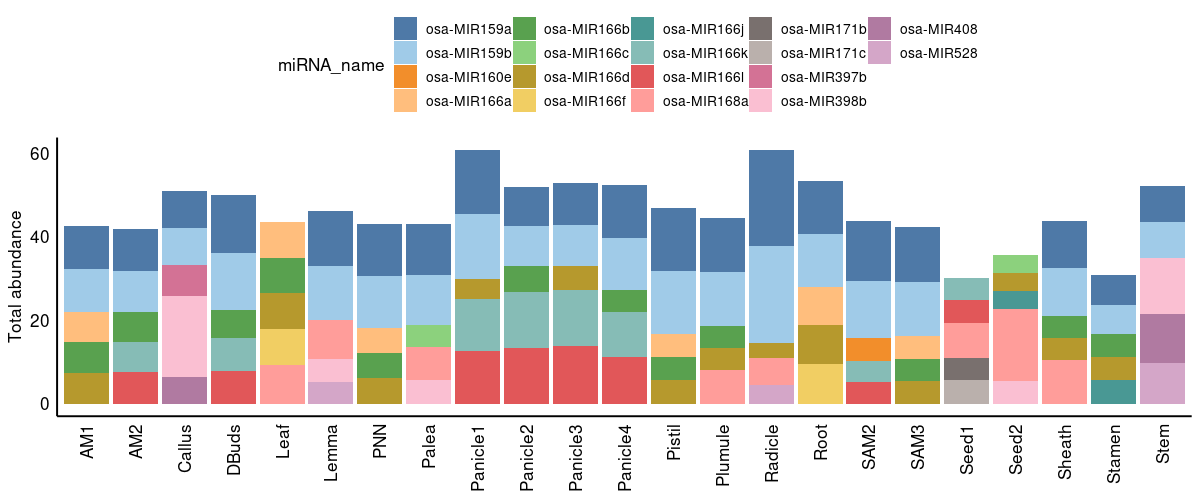

In [5]:
# Read data
ABD <- read.table('~/mirnome_data/2_quant/matrix/scale_tpm/microRNA_tpm.csv',
                 header = TRUE, row.names = 1, sep = '\t', stringsAsFactors = FALSE)

# Calculate percentage
percent <- data.frame(lapply(ABD, function(x) x / sum(x)))
rownames(percent) <- rownames(ABD)
percent$miRNA_name <- rownames(percent)

# Reshape data
melted_data <- melt(percent, id.vars = 'miRNA_name')

# Select top 5 for each variable
top5 <- melted_data %>% 
  group_by(variable) %>% 
  top_n(5, value) %>%
  mutate(percent = value * 100)

# Define color palette
myColor <- c('#4E79A7', '#A0CBE8', '#F28E2B', '#FFBE7D', '#59A14F', '#8CD17D', '#B6992D', '#F1CE63', 
             '#499894', '#86BCB6', '#E15759', '#FF9D9A', '#79706E', '#BAB0AC', '#D37295', '#FABFD2', 
             '#B07AA1', '#D4A6C8', '#9D7660', '#D7B5A6', '#B66353', '#D7CE9F', '#B9AA97', '#7E756D')

# Set plot options
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 100)

# Create the bar plot
p5 <- ggplot(top5, aes(x = variable, weight = percent, fill = miRNA_name)) +
  geom_bar(position = "stack") +
  theme_pubr() +
  scale_fill_manual(values = myColor) +
  labs(y = 'Total abundance', x = '') +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
    axis.title.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank()
  )

# Display the plot
p5

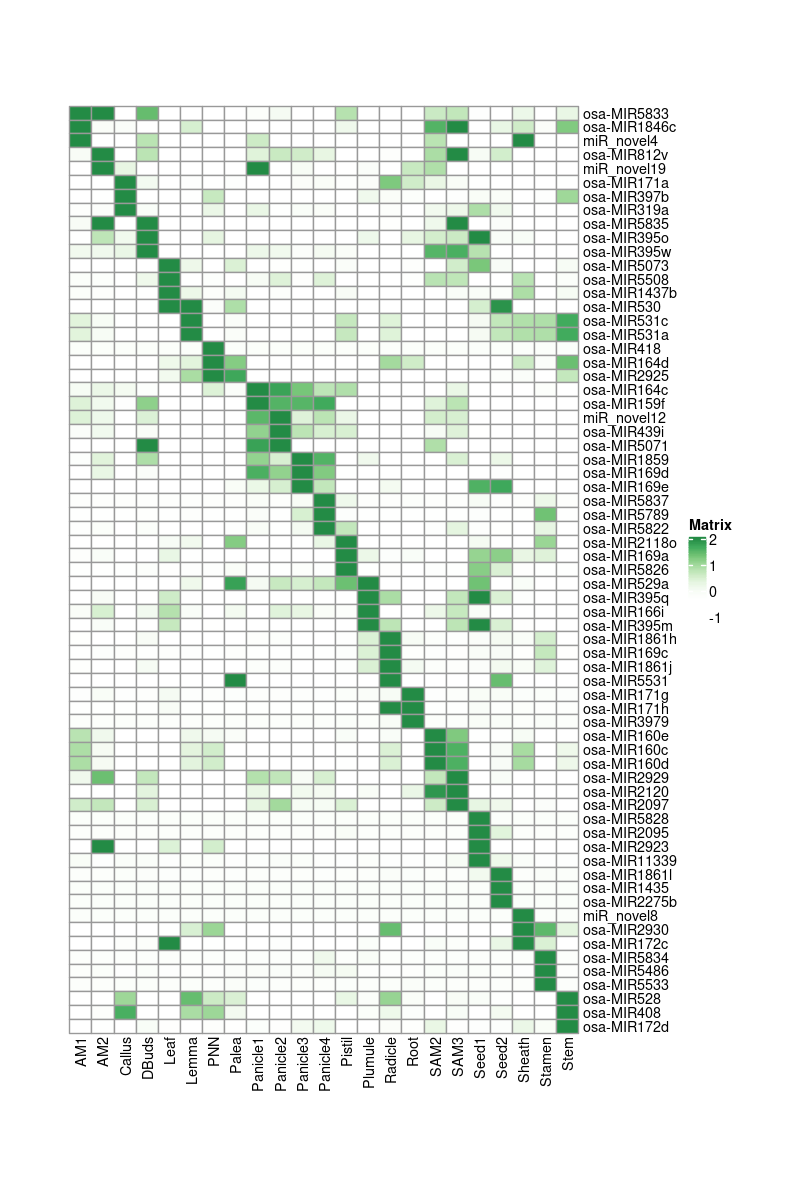

In [6]:
df <- readRDS("./Plot/spm_top3_23tissue_express.RDS")
orderMatrix <- function(mat){
  getQuantiles <- function(v = NULL, len = length(v)){
    if(length(v) < len){
      v2 <- rep(0, len)
      v2[seq_along(v)] <- v
    }else{
      v2 <- v
    }
    p <- trunc(rank(v2))/length(v2)
    if(length(v) < len){
      p <- p[seq_along(v)]
    }
    return(p)
  }
  scaled_rows <- mat #t(scale(t(as.matrix(mat))))
  scaled_rows <- scaled_rows[,colSums(scaled_rows)!= 0]
  varQ <- getQuantiles(matrixStats::rowVars(scaled_rows))
  mat <- scaled_rows[order(varQ, decreasing = TRUE), ]
  idx <- order(apply(mat, 1, which.max))
  res <- mat[idx, ]
  return(rowZscores(res,limit = T))
}

rowZscores <- function(m = NULL, min = -2, max = 2, limit = FALSE){
  z <- sweep(m - rowMeans(m), 1, matrixStats::rowSds(m),`/`)
  if(limit){
    z[z > max] <- max
    z[z < min] <- min
  }
  return(z)
}
clust <- hclust(dist(df %>% as.matrix()))
df <- df[clust$labels[clust$order],]
df <- orderMatrix(df)
options(repr.plot.width = 8, repr.plot.height =12, repr.plot.res = 100)
p1 <- ComplexHeatmap::pheatmap(df, cluster_rows = F, cluster_cols = F,
         color=c("white","white","white",paletteer_d("RColorBrewer::Greens")[1:7]),cellwidth=16,cellheight = 10)
p1

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


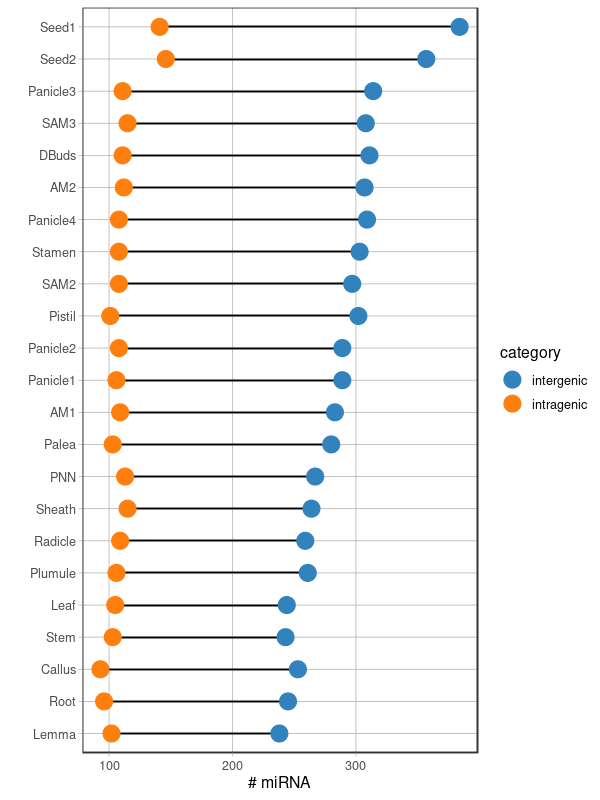

In [7]:
df <- readRDS("./Plot/23Tissue_express_cutoff2_miRNA_num.RDS")
df <- df[rev(order(df$total)),]
df1 <- df[,c("intergenic","intragenic")]
# df1$tissue <- rownames(df1)
# df1
library(tidyr)
long_matrix <- gather(df1, key = "category", value = "value") %>% mutate(tissue = rep(rownames(df1),2))
long_matrix$tissue <- factor(long_matrix$tissue,levels=rev(rownames(df)))
pro <- long_matrix %>%
  filter(category == "intergenic")
cols <- setNames(c("lightgrey",rev(paletteer_d("ggsci::default_locuszoom"))[2:7]),c("Balanced","NIP dominant","MH63 dominant","ZS97 dominant","NIP suppressed","MH63 suppressed","ZS97 suppressed"))
#options(repr.plot.width = 4, repr.plot.height = 5, repr.plot.res = 100)
pro <- long_matrix %>%
  filter(category == "intergenic")
Enh <- long_matrix %>%
  filter(category == "intragenic")
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 100)
p1 <- ggplot(long_matrix)+ geom_segment(data=pro, aes(x=value, xend=Enh$value, y=tissue, yend=Enh$tissue)) +
  geom_point(aes(x = value, y = tissue, color = category), size = 5, show.legend = TRUE) +
  ylab("") +
  xlab("# miRNA")+theme_bw()+theme(
    plot.title = element_text(face = "bold", size = 12),
    axis.ticks = element_line(colour = "grey70", size = 0.2),
    panel.grid.major = element_line(colour = "grey70", size = 0.2),
    panel.grid.minor = element_blank())+scale_color_manual(values = c("#3182BD","#FF7F0E"))
options(repr.plot.width = 6, repr.plot.height =8, repr.plot.res = 100)
p1

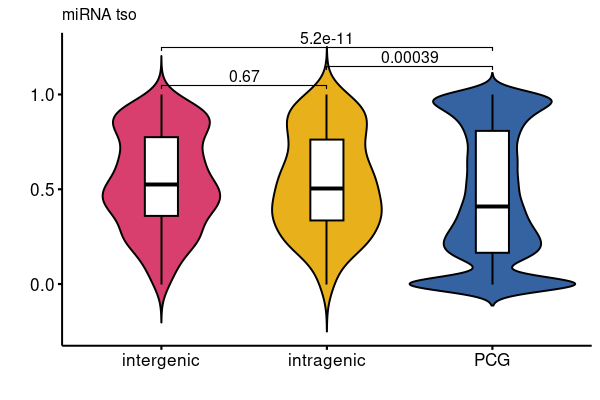

In [8]:
tau_miRNA_PCG <- read.csv("./Plot/tau_inter_intra_PCG.tsv",sep="\t")
options(repr.plot.height=4,repr.plot.width=6)
p1 <- ggviolin(tau_miRNA_PCG,"category","tau",fill="category",add = "boxplot", add.params = list(fill = "white"),palette = c("#D83F6E", "#E8B11C","#3563A1"))+
    theme(legend.position="none",plot.title = element_text(size=11)) +
    ggtitle(paste0("miRNA tso")) +ylab("")+
    xlab(" ")+ geom_signif(comparisons = list(c("intergenic","intragenic"),c("intragenic","PCG"),c("intergenic","PCG")),#设置需要比较的组
              test = t.test, ##计算方法
              y_position = c(1,1.1,1.2),#图中横线位置设置
              tip_length = c(c(0.02,0.02),c(0.02,0.02),c(0.02,0.02)),#横线下方的竖线设置
              size=0.3,color="black")
p1